<a href="https://colab.research.google.com/github/skywalker0803r/DIAYN/blob/main/DIYAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
num_skills = 2
total_timesteps = 30000
env_name = "BipedalWalker-v3"

In [2]:
!pip install stable_baselines3 >log.txt

In [3]:
!pip install box2d-py

In [4]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [5]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [6]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [7]:
!pip install ffmpeg

In [8]:
import gym
from gym import Wrapper,spaces
from torch.optim import Adam
import torch.nn.functional as F
import random
import numpy as np
from stable_baselines3 import SAC
import torch
from torch import nn

class DIAYN_Skill_Wrapper(Wrapper):
    def __init__(self, env, num_skills):
        Wrapper.__init__(self, env)
        self.num_skills = num_skills
        self.state_size = env.observation_space.shape[0]
        self.hidden_size = 128
        
        # discriminator 負責 state到skill 的映射 
        self.discriminator = nn.Sequential(
            nn.Linear(self.state_size,self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size,self.num_skills)
            )

        # discriminator優化器
        self.discriminator_optimizer = Adam(self.discriminator.parameters(),lr=1e-3)
        
        # skill的概率分布為 均勻分布
        self.prior_probability_of_skill = 1.0 / self.num_skills
        
        # 在原本的狀態維度多加一個維度代表skill
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,shape=(env.observation_space.shape[0] + 1,), dtype=np.float32)

    def reset(self, **kwargs):
        # 隨機採樣一個skill
        observation = self.env.reset(**kwargs)
        self.skill = random.randint(0, self.num_skills - 1)
        return self.observation(observation)

    def observation(self, observation):
        # 狀態跟skill組合起來返回
        return np.concatenate((np.array(observation), np.array([self.skill])))

    def step(self, action):
        # 這裡不使用原生reward
        next_state, _, done, info = self.env.step(action)
        # 使用一種技巧計算reward
        new_reward, discriminator_outputs = self.calculate_new_reward(next_state)
        # discriminator 學習預測正確的skill
        self.disciminator_learn(self.skill, discriminator_outputs)
        return self.observation(next_state), new_reward, done, info

    def calculate_new_reward(self, next_state):
        # 取得disciminator輸出以及在正確skill上的數值
        probability_correct_skill, disciminator_outputs =  self.get_predicted_probability_of_skill(self.skill, next_state)
        # 獎勵計算方式參考原始論文
        new_reward = np.log(probability_correct_skill + 1e-8) - np.log(self.prior_probability_of_skill)
        return new_reward, disciminator_outputs
    
    def disciminator_learn(self, skill, discriminator_outputs):
        # 計算disciminator輸出對上正確skill的交叉商
        loss = nn.CrossEntropyLoss()(discriminator_outputs, torch.Tensor([skill]).long())
        # 把梯度求出來
        loss.backward()
        # 更新disciminator
        self.discriminator_optimizer.step()
        # 梯度清空
        self.discriminator_optimizer.zero_grad()
    
    def get_predicted_probability_of_skill(self, skill, next_state):
        # discriminator 根據next_state預測可能的skill
        predicted_probabilities_unnormalised = self.discriminator(torch.Tensor(next_state).unsqueeze(0))
        # 正確的skill的概率
        probability_of_correct_skill = F.softmax(predicted_probabilities_unnormalised,dim=-1)[:, skill]
        return  probability_of_correct_skill.item(), predicted_probabilities_unnormalised
    


In [9]:
import gym
from stable_baselines3 import SAC

def train():
    env = gym.make(env_name)
    env = DIAYN_Skill_Wrapper(env,num_skills=num_skills)
    agent = SAC(
        "MlpPolicy", 
        env, 
        verbose=1,
        tensorboard_log="./tensorboard"
        )
    agent.learn(total_timesteps=total_timesteps)
    agent.save(f"sac_{env_name}")

In [10]:
train()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/SAC_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 457      |
|    ep_rew_mean     | 291      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 42       |
|    time_elapsed    | 43       |
|    total timesteps | 1828     |
| train/             |          |
|    actor_loss      | -22.3    |
|    critic_loss     | 0.12     |
|    ent_coef        | 0.596    |
|    ent_coef_loss   | -3.48    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1727     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 456      |
|    ep_rew_mean     | 282      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 41       |
|    time_elapsed    | 87       |
|    total timesteps | 36

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [12]:
def look_skill(skill_idx):
  class DIAYN_Skill_Wrapper_test(DIAYN_Skill_Wrapper):
    def observation(self, observation):
      self.skill = skill_idx #直接指定特定技能
      return np.concatenate((np.array(observation), np.array([self.skill])))
  display = Display(visible=0, size=(400, 300))
  display.start()
  import time
  env = gym.make(env_name)
  env = DIAYN_Skill_Wrapper_test(env,num_skills=num_skills)
  obs = env.reset()
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)
  model = SAC.load(f"sac_{env_name}.zip")
  frames = []
  for i in range(50):
    print(i)
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    frames.append(screen)
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    if done:
      break

  ipythondisplay.clear_output(wait=True)
  env.close()
  return frames

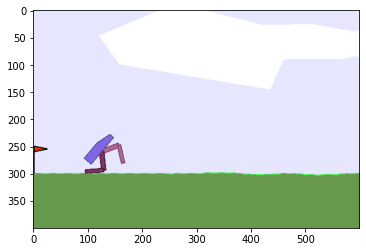

In [16]:
skill_0_frames = look_skill(0)

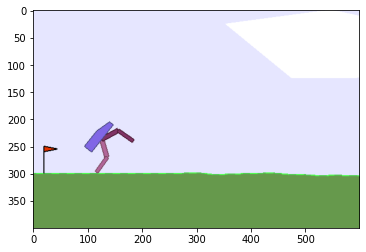

In [17]:
skill_1_frames = look_skill(1)